## готовим данные для rnn

### data set
https://www.kaggle.com/retailrocket/ecommerce-dataset

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import sklearn

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
### load data - загрузим данные из предыдущих анализов
events = pd.DataFrame.from_csv('./data/train_events_3.csv')

In [4]:
events.shape[0]

1355823

In [5]:
events.head()

,index,timestamp,visitorid,event,itemid,transactionid,delta,delta1,ssid,session_type,item_cat,item_cat_dist,event_type,session_transation_type
0,2024720,1438969904567,2,view,325215,-1,NaN,NaN,1,2,299.0,0.0,0,0
1,2024760,1438970013790,2,view,325215,-1,1.820383,1.820383,1,2,299.0,0.0,0,0
2,2024834,1438970212664,2,view,259884,-1,3.314567,3.314567,1,2,299.0,0.0,0,0
3,2024945,1438970468920,2,view,216305,-1,4.270933,4.270933,1,2,299.0,0.0,0,0
4,2025140,1438970905669,2,view,342816,-1,7.279150,7.279150,1,2,444.0,10.0,0,0


In [6]:
events.itemid.unique().shape[0]

147182

In [7]:
##уберем лишние данные

In [8]:
events_ = events.drop(['transactionid','delta','delta1', 'session_type','item_cat','item_cat_dist','event_type','session_transation_type'],axis=1)

In [9]:
##причешем датачет

In [10]:
events_['event_type'] = events.event.copy()

In [11]:
events_.event_type = events_.event_type.replace({'view': 0, 'addtocart': 1, 'transaction': 2})

In [12]:
events_['event_type'] = events_['event_type'].astype(int)

In [13]:
events_['ssid'] = events_['ssid'].astype(int)

In [14]:
events_.head()

,index,timestamp,visitorid,event,itemid,ssid,event_type
0,2024720,1438969904567,2,view,325215,1,0
1,2024760,1438970013790,2,view,325215,1,0
2,2024834,1438970212664,2,view,259884,1,0
3,2024945,1438970468920,2,view,216305,1,0
4,2025140,1438970905669,2,view,342816,1,0


In [15]:
events_ = events_.sort_values(['ssid', 'timestamp'], ascending=[True, True])

In [16]:
%%time
sessions_ =  events_[['ssid',
                     'event_type',
                     'itemid',
                     ]].groupby('ssid')

Wall time: 9.5 ms


In [17]:
seq = pd.DataFrame()

In [18]:
%%time
seq['actions'] = sessions_['event_type'].apply(list)
seq['items'] = sessions_['itemid'].apply(list)
seq['max_action'] = sessions_['event_type'].apply(max)

Wall time: 2min 26s


In [19]:
seq.reset_index(inplace=True)

In [20]:
seq.head()

,ssid,actions,items,max_action
0,1,"[0, 0, 0, 0, 0, 0, 0, 0]","[325215, 325215, 259884, 216305, 342816, 34281...",0
1,2,"[0, 0]","[139394, 164941]",0
2,3,[0],[226353],0
3,4,"[0, 0]","[320589, 278689]",0
4,5,"[0, 0]","[86411, 86411]",0


In [21]:
seq['len'] = seq.actions.apply(len)

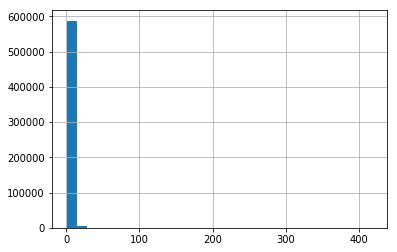

In [22]:
seq['len'].hist(bins=30)

In [23]:
seq['len'].loc[seq.max_action == 2].quantile([.99])

0.99    36.0
Name: len, dtype: float64

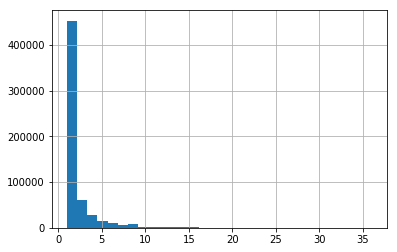

In [24]:
seq['len'].loc[seq['len'] <= 36].hist(bins=30)

In [25]:
def last_i(list):
    return list[-1]

#функция 
def train_seq(list):
    if len(list) > 36:
        return list[-36:]
    return list[:-1]

In [26]:
seq.shape

(592160, 5)

In [27]:
%%time
seq['action_last'] = seq.actions.apply(last_i)
seq['items__last'] = seq['items'].apply(last_i)
seq['action_train'] = seq.actions.apply(train_seq)
seq['items__train'] = seq['items'].apply(train_seq)

Wall time: 1.82 s


In [28]:
#seq.head()

In [29]:
seq.shape

(592160, 9)

In [30]:
seq_ = seq.loc[seq.len > 1]

In [31]:
#seq_ = seq.loc[seq.len > 2]

In [32]:
seq_.shape

(306474, 9)

In [33]:
seq_.head()

,ssid,actions,items,max_action,len,action_last,items__last,action_train,items__train
0,1,"[0, 0, 0, 0, 0, 0, 0, 0]","[325215, 325215, 259884, 216305, 342816, 34281...",0,8,0,325215,"[0, 0, 0, 0, 0, 0, 0]","[325215, 325215, 259884, 216305, 342816, 34281..."
1,2,"[0, 0]","[139394, 164941]",0,2,0,164941,[0],[139394]
3,4,"[0, 0]","[320589, 278689]",0,2,0,278689,[0],[320589]
4,5,"[0, 0]","[86411, 86411]",0,2,0,86411,[0],[86411]
6,7,"[0, 0]","[283916, 283916]",0,2,0,283916,[0],[283916]


In [34]:
seq_.action_last.value_counts()

0    283536
1     12402
2     10536
Name: action_last, dtype: int64

In [35]:
data = seq_.copy()
target = seq_['action_last'].copy()

In [36]:
data['len'] = data['action_train'].apply(len)

In [37]:
data.len.max()

36

In [38]:
target = target.replace({0:0, 1:0, 2:1})

In [39]:
target.value_counts()

0    295938
1     10536
Name: action_last, dtype: int64

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target,shuffle =True)

In [41]:
X_train.shape

(245179, 9)

In [42]:
X_test.shape

(61295, 9)

In [43]:
y_train.value_counts()

0    236750
1      8429
Name: action_last, dtype: int64

In [44]:
y_test.value_counts()
#баланс классов в трейн/тест сохранили

0    59188
1     2107
Name: action_last, dtype: int64

In [45]:
X_train.head()

,ssid,actions,items,max_action,len,action_last,items__last,action_train,items__train
497975,497976,"[1, 1]","[47526, 47526]",1,1,1,47526,[1],[47526]
301321,301322,"[0, 0]","[452896, 354759]",0,1,0,354759,[0],[452896]
342887,342888,"[0, 0, 0]","[72430, 438419, 72430]",0,2,0,72430,"[0, 0]","[72430, 438419]"
473731,473732,"[0, 0, 0]","[116802, 153118, 153118]",0,2,0,153118,"[0, 0]","[116802, 153118]"
523783,523784,"[0, 0, 0]","[53754, 53754, 226160]",0,2,0,226160,"[0, 0]","[53754, 53754]"


In [46]:
#сбалансируем тренинг выборку

In [47]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_sample(X_train[['ssid']], y_train)

In [48]:
y_resampled_ = pd.DataFrame()
y_resampled_['target'] = y_resampled

In [49]:
X_resampled_ = pd.DataFrame()
X_resampled_['ssid'] = X_resampled[:,0]

In [50]:
y_resampled_.target.value_counts()

1    236750
0    236750
Name: target, dtype: int64

In [51]:
temp = X_resampled_.merge(X_train, left_on='ssid', right_on='ssid', how='left')

In [52]:
y_resampled_['target'] = temp['action_last'] 

In [53]:
#оставляем только 2 класса 

In [54]:
y_resampled_['target'] = y_resampled_['target'].replace({0:0, 1:0, 2:1})

## RNN

In [55]:
import keras
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import concatenate, Concatenate, Merge, Input,Add
from keras import regularizers

Using TensorFlow backend.


In [56]:
keras.backend.clear_session()

In [57]:
max_features_1 = 100
max_features_2 = 100
maxlen =  data.len.max()
batch_size = 128
n_actions, n_items = 3, events.itemid.unique().shape[0]+1 

In [58]:
#приводим последовательность к одной длинне

In [59]:
X_train_1 = sequence.pad_sequences(temp['action_train'], maxlen=maxlen,value=(np.nan))
X_train_2 = sequence.pad_sequences(temp['items__train'], maxlen=maxlen,value=(np.nan))

In [60]:
X_test_1 = sequence.pad_sequences(X_test['action_train'], maxlen=maxlen, value=(np.nan))
X_test_2 = sequence.pad_sequences(X_test['items__train'], maxlen=maxlen, value=(np.nan))

In [61]:
#модель

In [62]:
actions_input     = Input(batch_shape=(None,maxlen),dtype='int32', name='actions')
actions_embedding = Embedding(output_dim=max_features_1, input_dim=n_actions, input_length=maxlen)(actions_input)

items_input     = Input( batch_shape=(None,maxlen), dtype='int32', name='items')
items_embedding = Embedding(output_dim=max_features_2, input_dim=n_items+1, input_length=maxlen,)(items_input)

layer_0 = Concatenate()([actions_embedding, items_embedding])

layer_1 = GRU(max_features_1+max_features_2,return_sequences=True,recurrent_dropout=0.5, dropout=0.5)(layer_0)
layer_2 = GRU(max_features_1+max_features_2,recurrent_regularizer=regularizers.l2(0.01),recurrent_dropout=0.5, dropout=0.5,activation="relu")(layer_1)

layer_3 = Dense(4,activation="softmax")(layer_2)
layer_4 = Dense(2)(layer_3)
layer_5 = Activation('softmax')(layer_4)

model_ = Model(inputs=[actions_input, items_input,], outputs=[layer_5])

In [63]:
model_.reset_states()

In [64]:
# rmsprop  categorical_crossentropy   binary_crossentropy accuracy               metrics=['binary_accuracy', 'categorical_accuracy'])

In [65]:
model_.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', 'categorical_accuracy'])

In [66]:
model_.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
actions (InputLayer)             (None, 36)            0                                            
____________________________________________________________________________________________________
items (InputLayer)               (None, 36)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 36, 100)       300         actions[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 36, 100)       14718400    items[0][0]                      
___________________________________________________________________________________________

In [67]:
model_.fit(
    x ={ 'actions': X_train_1, 'items' : X_train_2}, y= keras.utils.to_categorical(y_resampled_['target'], num_classes=2), 
    batch_size = 125, 
    epochs=10,
    verbose= 1,
)

Epoch 1/10
473500/473500 [==============================] - 406s - loss: 0.2949 - binary_accuracy: 0.9216 - categorical_accuracy: 0.9216   
Epoch 2/10
473500/473500 [==============================] - 397s - loss: 0.2241 - binary_accuracy: 0.9351 - categorical_accuracy: 0.9351   
Epoch 3/10
473500/473500 [==============================] - 407s - loss: 0.2150 - binary_accuracy: 0.9366 - categorical_accuracy: 0.9366   
Epoch 4/10
473500/473500 [==============================] - 400s - loss: 0.2133 - binary_accuracy: 0.9372 - categorical_accuracy: 0.9372   
Epoch 5/10
473500/473500 [==============================] - 398s - loss: 0.2120 - binary_accuracy: 0.9376 - categorical_accuracy: 0.9376   
Epoch 6/10
473500/473500 [==============================] - 394s - loss: 0.2101 - binary_accuracy: 0.9379 - categorical_accuracy: 0.9379   
Epoch 7/10
473500/473500 [==============================] - 395s - loss: 0.2094 - binary_accuracy: 0.9383 - categorical_accuracy: 0.9383   
Epoch 8/10
473500/47

In [68]:
%%time
y_pred = model_.predict(x ={'actions': X_test_1, 'items' : X_test_2}, verbose=1,batch_size=128)

61295/61295 [==============================] - 10s    
Wall time: 10.4 s


In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [70]:
confusion_matrix(y_test, y_pred.argmax(axis=-1))

array([[56775,  2413],
       [  361,  1746]], dtype=int64)

In [71]:
accuracy_score(y_test, y_pred.argmax(axis=-1))

0.9547434537890529

In [72]:
print(classification_report(y_test ,y_pred.argmax(axis=-1)))

             precision    recall  f1-score   support

          0       0.99      0.96      0.98     59188
          1       0.42      0.83      0.56      2107

avg / total       0.97      0.95      0.96     61295



In [73]:
model_.save('my_model_1.h5')

In [74]:
import seaborn as sn

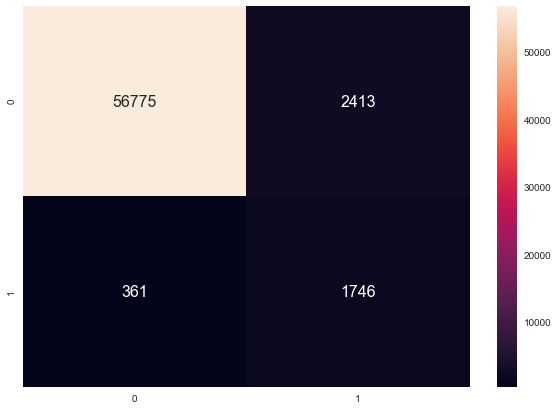

In [75]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1)
sn.heatmap(confusion_matrix(y_test, y_pred.argmax(axis=-1)), annot=True,annot_kws={"size": 16} ,fmt="d")

In [76]:
from sklearn.metrics import precision_recall_curve, roc_curve ,auc, roc_auc_score

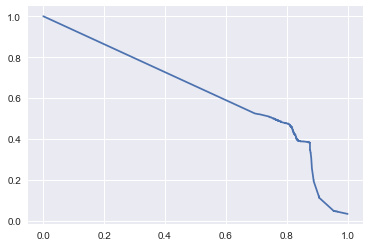

In [77]:
pr, re, thres = precision_recall_curve(y_test, y_pred[:, 1] )
plt.plot( re, pr )
# построим precision - recall кривую

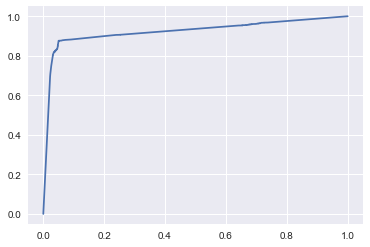

In [78]:
fpr, tpr, thres = roc_curve(y_test, y_pred[:, 1] )
plt.plot( fpr, tpr )
# построим ROC-кривую (Receiver Operating Characteristic)

In [79]:
#Дообучим модель на тестовой выборке

In [80]:
X_test_r, y_test_r = ros.fit_sample(X_test[['ssid']], y_test)

In [81]:
y_test_r_ = pd.DataFrame()
y_test_r_['target'] = y_test_r

In [82]:
X_test_r_ = pd.DataFrame()
X_test_r_['ssid'] = X_test_r[:,0]

In [83]:
y_test_r_.target.value_counts()

1    59188
0    59188
Name: target, dtype: int64

In [84]:
temp_ = X_test_r_.merge(X_test, left_on='ssid', right_on='ssid', how='left')

In [85]:
X_test_1_ = sequence.pad_sequences(temp_['action_train'], maxlen=maxlen, value=(np.nan))
X_test_2_ = sequence.pad_sequences(temp_['items__train'], maxlen=maxlen, value=(np.nan))

In [86]:
model_.fit(
    x ={ 'actions': X_test_1_, 'items' : X_test_2_}, y= keras.utils.to_categorical(y_test_r_, num_classes=2), 
    batch_size = 115, 
    epochs=10,
    verbose= 1,
)

Epoch 1/10
118376/118376 [==============================] - 107s - loss: 0.2502 - binary_accuracy: 0.9244 - categorical_accuracy: 0.9244   
Epoch 2/10
118376/118376 [==============================] - 107s - loss: 0.2098 - binary_accuracy: 0.9384 - categorical_accuracy: 0.9384   
Epoch 3/10
118376/118376 [==============================] - 107s - loss: 0.1985 - binary_accuracy: 0.9420 - categorical_accuracy: 0.9420   
Epoch 4/10
118376/118376 [==============================] - 107s - loss: 0.1926 - binary_accuracy: 0.9436 - categorical_accuracy: 0.9436   
Epoch 5/10
118376/118376 [==============================] - 107s - loss: 0.1868 - binary_accuracy: 0.9452 - categorical_accuracy: 0.9452   
Epoch 6/10
118376/118376 [==============================] - 107s - loss: 0.1823 - binary_accuracy: 0.9467 - categorical_accuracy: 0.9467   
Epoch 7/10
118376/118376 [==============================] - 107s - loss: 0.1794 - binary_accuracy: 0.9474 - categorical_accuracy: 0.9474   
Epoch 8/10
118376/11

In [87]:
#сохраним модель для ее валидации на отложеной выборке

In [88]:
model_.save('my_model_2.h5')